## Initial import

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil
from glob import glob 

from sklearn.utils import shuffle 
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

## Specify a GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [23]:
base_dir = '/data/liu/dog_breeds/'
train_dir = '/data/liu/dog_breeds/train/'
test_dir = '/data/liu/dog_breeds/test/'
origin_data_dir = '/data/liu/all_images/'
# train_folder = os.path.join(base_dir,'base_dir/train')
# valid_folder = os.path.join(base_dir,'base_dir/valid')
# test_folder = os.path.join(base_dir,'base_dir/test')
train_folder = os.path.join(base_dir,'split_set/train')
valid_folder = os.path.join(base_dir,'split_set/valid')
test_folder = os.path.join(base_dir,'split_set/test')

In [13]:
# test_df = pd.read_csv(os.path.join(base_dir,"test_label_name.csv"))
# df_train = pd.read_csv(os.path.join(base_dir,'df_train.csv'))
# df_val = pd.read_csv(os.path.join(base_dir,'df_val.csv'))
test_df = pd.read_csv(os.path.join(base_dir,"df_test.csv"))
df_train = pd.read_csv(os.path.join(base_dir,'df_train.csv'))
df_val = pd.read_csv(os.path.join(base_dir,'df_val.csv'))

## Only run for the first time: split training data into training and validation

In [3]:
# df = pd.DataFrame({'path': glob(os.path.join(base_dir,'*.jpg'))})
train_df = pd.read_csv(os.path.join(base_dir,"train_label_name.csv"))
# df_data = df.merge(labels, on = "id")
train_df .head()

,id,breed_id,breed
0,n02106382_112.jpg,n02106382,Bouvier_des_Flandres
1,n02096294_4535.jpg,n02096294,Australian_terrier
2,n02096294_6785.jpg,n02096294,Australian_terrier
3,n02107312_3673.jpg,n02107312,miniature_pinscher
4,n02113023_7914.jpg,n02113023,Pembroke


In [4]:
test_df = pd.read_csv(os.path.join(base_dir,"test_label_name.csv"))
# df_data = df.merge(labels, on = "id")
test_df.head()

,id,breed_id,breed
0,n02108000_2464.jpg,n02108000,EntleBucher
1,n02112350_9195.jpg,n02112350,keeshond
2,n02088238_10072.jpg,n02088238,basset
3,n02091244_3631.jpg,n02091244,Ibizan_hound
4,n02095570_3534.jpg,n02095570,Lakeland_terrier


In [6]:
## split tarining data into training set and validation set
train_y = train_df['breed']
test_y = test_df['breed']
df_train, df_val = train_test_split(train_df, test_size=0.10, random_state=101, stratify=train_y)

In [14]:
## save training set and validation set into files
df_train.to_csv(os.path.join(base_dir,'df_train.csv'),index=False)
df_val.to_csv(os.path.join(base_dir,'df_val.csv'),index=False)

In [9]:
# Set the id as the index in train_df
train_df.set_index('id', inplace=True)
train_df.head()

,breed_id,breed
id,,
n02106382_112.jpg,n02106382,Bouvier_des_Flandres
n02096294_4535.jpg,n02096294,Australian_terrier
n02096294_6785.jpg,n02096294,Australian_terrier
n02107312_3673.jpg,n02107312,miniature_pinscher
n02113023_7914.jpg,n02113023,Pembroke


In [10]:
# Set the id as the index in test_df
test_df.set_index('id', inplace=True)
test_df.head()

,breed_id,breed
id,,
n02108000_2464.jpg,n02108000,EntleBucher
n02112350_9195.jpg,n02112350,keeshond
n02088238_10072.jpg,n02088238,basset
n02091244_3631.jpg,n02091244,Ibizan_hound
n02095570_3534.jpg,n02095570,Lakeland_terrier


In [9]:
#Create folder fistly
train_y = pd.read_csv(os.path.join(base_dir,'all_dogs.csv'))['breed']

train_folder = os.path.join(base_dir,'split_set/train')
valid_folder = os.path.join(base_dir,'split_set/valid')
test_folder = os.path.join(base_dir,'split_set/test')
for fold in [train_folder, valid_folder, test_folder]:
    for subf in train_y.unique():
        os.makedirs(os.path.join(fold, subf))

In [24]:
## copy images into new generated training and validation directory. src, dsg -> original path, destination path
# df_train.set_index('id', inplace=True)
# df_val.set_index('id', inplace=True)
# test_df.set_index('id', inplace=True)

for image in df_train.index.values:
    breed = str(df_train.loc[image,'breed']) # get the label for a certain image
    src = os.path.join(origin_data_dir, image)
    dst = os.path.join(train_folder, breed, image)
    shutil.copyfile(src, dst)
    
for image in df_val.index.values:
    breed = str(df_val.loc[image,'breed']) # get the label for a certain image
    src = os.path.join(origin_data_dir, image)
    dst = os.path.join(valid_folder, breed, image)
    shutil.copyfile(src, dst)


In [25]:
## copy test images (breeds as folders' names)

for image in test_df.index.values:
    breed = str(test_df.loc[image,'breed']) # get the label for a certain image
    src = os.path.join(origin_data_dir, image)
    dst = os.path.join(test_folder, breed, image)
    shutil.copyfile(src, dst)

In [6]:
## train model

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

## Image Data Preprocessing

In [26]:
IMAGE_SIZE = 200
num_train_samples = len(df_train)
num_val_samples = len(df_val)
num_test_samples = len(test_df)

train_batch_size = 32
val_batch_size = 32
test_batch_size = 32
print("Num of train samples: %d" % num_train_samples)
print("Num of validation samples: %d" % num_val_samples)
print("Num of test samples: %d" % num_test_samples)

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)
print("train_steps: %d" % train_steps)
print("val_steps: %d" % val_steps)
print("test_steps: %d" % test_steps)

Num of train samples: 13171
Num of validation samples: 3293
Num of test samples: 4116
train_steps: 412
val_steps: 103
test_steps: 129


In [27]:
from keras.preprocessing.image import ImageDataGenerator
## Noramlize RGB values
datagen = ImageDataGenerator(
    rescale=1./255,
    # preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
    horizontal_flip=True,
    vertical_flip=True)

In [28]:
train_gen = datagen.flow_from_directory(train_folder,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_folder,
                                      target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                      batch_size=val_batch_size,
                                      class_mode='categorical')

test_gen = datagen.flow_from_directory(test_folder,
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       batch_size=test_batch_size,
                                       class_mode='categorical',
                                       shuffle=False)

Found 13171 images belonging to 120 classes.
Found 3293 images belonging to 120 classes.
Found 4116 images belonging to 120 classes.


## InceptionResNetV2 Model

In [29]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Sequential, Model
from keras import layers
from keras import optimizers
from keras.layers import Concatenate, BatchNormalization, Flatten, Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D

IMG_SIZE = (200, 200)
IN_SHAPE = (*IMG_SIZE, 3)

dropout_dense=0.5

conv_base = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=IN_SHAPE
)

model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(layers.Dense(120, activation = "sigmoid"))

conv_base.summary()
conv_base.Trainable=True

from keras import optimizers

# conv_base.trainable = False
model.compile(optimizers.Adam(0.0001), loss = 'categorical_crossentropy', metrics=["accuracy"])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 99, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [30]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
h5_path = "inception_resnet_v2_model1.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1,restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr = 0.000000001)
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                              validation_data=val_gen, validation_steps=val_steps,
                              epochs=20,
                              callbacks=[reducel, checkpoint])

Epoch 1/20
412/412 [==============================] - 240s 582ms/step - loss: 2.6369 - acc: 0.4405 - val_loss: 1.7721 - val_acc: 0.5633

Epoch 00001: val_acc improved from -inf to 0.56332, saving model to inception_resnet_v2_model1.h5
Epoch 2/20
412/412 [==============================] - 202s 490ms/step - loss: 1.1856 - acc: 0.6681 - val_loss: 1.3537 - val_acc: 0.6389

Epoch 00002: val_acc improved from 0.56332 to 0.63893, saving model to inception_resnet_v2_model1.h5
Epoch 3/20
412/412 [==============================] - 202s 490ms/step - loss: 0.7796 - acc: 0.7728 - val_loss: 1.2273 - val_acc: 0.6611

Epoch 00003: val_acc improved from 0.63893 to 0.66110, saving model to inception_resnet_v2_model1.h5
Epoch 4/20
412/412 [==============================] - 203s 492ms/step - loss: 0.5650 - acc: 0.8297 - val_loss: 1.3817 - val_acc: 0.6547

Epoch 00004: val_acc did not improve from 0.66110
Epoch 5/20
412/412 [==============================] - 203s 492ms/step - loss: 0.4283 - acc: 0.8686 - v

In [33]:
# accuracy metric 1
from keras.metrics import categorical_accuracy
result = model.evaluate_generator(test_gen,steps = test_steps)
print(model.metrics_names)
print(result)

['loss', 'acc']
[1.167238780082836, 0.7395529640717223]


In [64]:
# accuracy metric 2
## return the probability of each class
# probs_120 = model.predict_generator(test_gen,steps = test_steps,verbose=1)
# y_pred = np.argmax(probs_120,axis=1)
# accuracy_score(test_gen.classes, y_pred)

0.738581146744412

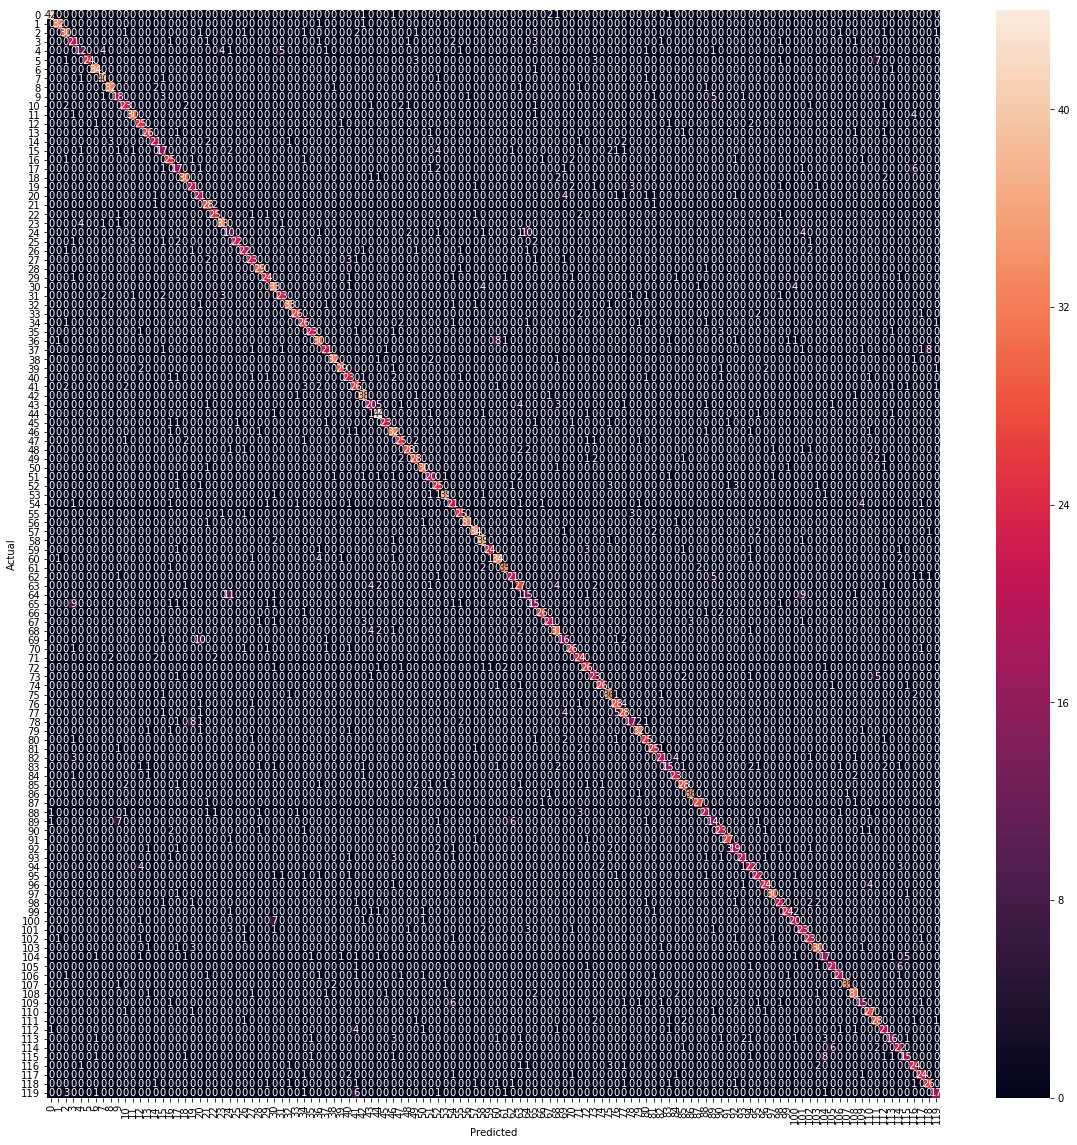

In [74]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_gen.classes, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=range(0,120), yticklabels=range(0,120))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [31]:
#!python -c 'import keras; print(keras.__version__)'